# Tech challenge - Grupo 9 - É chikungunya?

## Sobre


### Dicionario de dados das colunas utilizadas

[Link detalhado](./dicionario_dados_colunas_utilizadas.md)


### Variáveis:

- df_original: valor do dataframe sem modificação
- df: valor do dataframe modificado ao longo dos blocos
- cols_sintomas: nomes de colunas relacionadas a sintomas
- cols_comorbidades: nomes de colunas relacionadas a sintomas 
- cols_exames: nomes de colunas relacionadas a exame
- col_target: nome da coluna target
- colunas_selecionada: soma de todas as colunas

### Links Úteis

- [Informações sobre a de dados](https://dadosabertos.saude.gov.br/dataset/arboviroses-febre-de-chikungunya)
- [Dicionário de dados](./dic_dados_chikungunya.pdf)
- [Base de dados 2025](./dados/CHIKBR25.csv)


## Requisitos

In [146]:
! pip install -r requirements.txt

## Importações e configurações

In [147]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [148]:
df_original = pd.read_csv("./dados/CHIKBR25.csv", low_memory=False)
df_original.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,NU_LOTE_I,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A920,2024-12-30,202501,2024,32,320060,32001.00,2449218.00,2024-12-30,202501,1989.00,4035,F,5.00,1,6.00,32,320060.00,32001.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,4.00,NaN,4.00,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
1,2,A920,2024-12-30,202501,2024,32,320405,32003.00,2484536.00,2024-12-29,202501,1980.00,4044,M,5.00,4,9.00,32,320405.00,32003.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,1.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,13.00,1.00,NaN,NaN,1.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
2,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1996.00,4028,M,6.00,4,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
3,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1979.00,4045,F,5.00,1,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
4,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,2008.00,4016,F,5.00,4,9.00,32,320130.00,32002.00,1,2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN

## Análise Exploratória de Dados (EDA)

In [149]:
# Quantidade de linhas e colunas
df_original.shape

(248541, 122)

In [150]:
# Analisando as informações do dataset
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248541 entries, 0 to 248540
Columns: 122 entries, TP_NOT to MIGRADO_W
dtypes: float64(94), int64(10), object(18)
memory usage: 231.3+ MB


### Análise de correlação

#### Correlação entre todas as colunas

Análise:
Podemos observar uma grande correlacao entre as colunas de MUNICIPIO, UF, CRITERIO..., mas estao relacionadas em como definir a dengue no passado. 
Para saber se o paciente tem dengue atualmente, nao deveria levar em consideração a regiao. 

In [151]:
import numpy as np

df_original_copy = df_original.copy()

null_threshold = 0.99

df_original_copy = df_original_copy.loc[:, df_original_copy.isnull().mean() < null_threshold]


df_corr_target = df_original_copy.select_dtypes(include=[np.number]).corr()['CLASSI_FIN']


df_nulos_contagem = df_original_copy.isnull().sum()

df_analise = pd.concat([df_corr_target, df_nulos_contagem], axis=1)

# Renomeando as colunas para facilitar a leitura
df_analise.columns = ['Correlacao_com_Alvo', 'Qtd_Nulos']

total_linhas = len(df_original_copy) 
df_analise['Percent_Nulos'] = (df_analise['Qtd_Nulos'] / total_linhas) * 100

# 7. FILTRAR E ORDENAR
# Removemos a própria linha 'CLASSI_FIN' da análise (pois a correlação dela com ela mesma é 1)
df_analise = df_analise.drop(index='CLASSI_FIN', errors='ignore')
df_analise.sort_values(by='Correlacao_com_Alvo', ascending=False)

,Correlacao_com_Alvo,Qtd_Nulos,Percent_Nulos
MUNICIPIO,0.15,239164,96.23
UF,0.14,239007,96.16
CRITERIO,0.12,18824,7.57
ID_MN_RESI,0.11,2,0.00
ID_MUNICIP,0.11,0,0.00
SG_UF,0.11,0,0.00
SG_UF_NOT,0.11,0,0.00
RESUL_PCR_,0.04,97023,39.04
RESUL_VI_N,0.04,135697,54.60
NU_IDADE_N,0.04,0,0.00


In [152]:
df_original['NU_ANO'].value_counts()

NU_ANO
2025    248317
2024       200
2026        24
Name: count, dtype: int64

#### Correlação entre colunas

Análise:
Para a classi_fin as colunas estao bem distribuidas sem nenhum detaque aparente. 
Tem algumas colunas que se relacionam entre si, como Vomito e Nausea, Dor nas costas e Artrite e Diabetes e Hipertensão

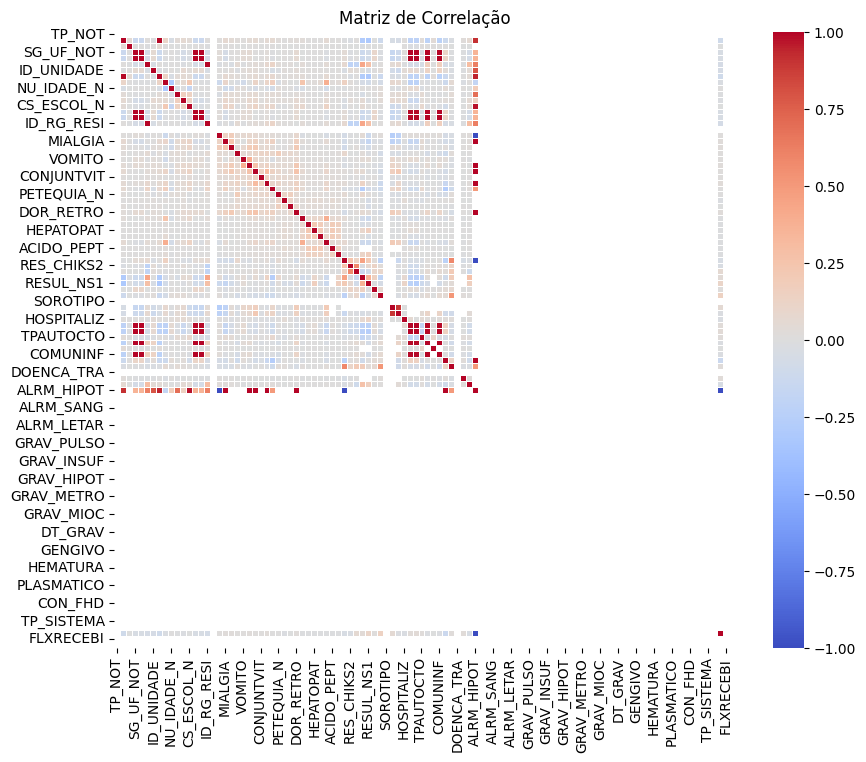

In [153]:
df_corr = df_original.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(df_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)

plt.title('Matriz de Correlação')
plt.show()

### Separando colunas da base de dados referentes a sintomas, comorbidades e exames que possam fazer sentido para o treinamento

In [154]:
cols_sintomas = [
		'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS',
		'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO',
		'DOR_RETRO'
]

cols_comorbidades = [
		'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
		'ACIDO_PEPT', 'AUTO_IMUNE', 
]

cols_exames = [
		'HISTOPA_N', 'IMUNOH_N', 'RESUL_PCR_', 'RESUL_VI_N', 'CLINC_CHIK'
]

col_target = [
		'CLASSI_FIN'
]

# Colunas adicionais para análise de contexto e fatores demográficos
colunas_adicionais = ['NU_IDADE_N', 'ID_MN_RESI', 'CS_SEXO', 'RESUL_PRNT']

colunas_selecionadas = cols_sintomas + cols_comorbidades + cols_exames + colunas_adicionais + col_target
df = df_original[colunas_selecionadas].copy()

In [155]:
df.shape

(248541, 31)

In [156]:
df['HISTOPA_N'].value_counts()

HISTOPA_N
4.00    158
2.00      1
Name: count, dtype: int64

In [157]:
# Removendo campo HISTOPA_N pois só tem valor 4 (Não realizado) e 2 (Não Reagente)
df = df.drop(columns=['HISTOPA_N'])

In [158]:
df['IMUNOH_N'].value_counts()

IMUNOH_N
4.00    158
2.00      1
3.00      1
Name: count, dtype: int64

In [159]:
# Removendo campo HISTOPA_N pois só tem valor 4 (Não realizado), 2 (Não Reagente) e 3 (Inconclusivo)
df = df.drop(columns=['IMUNOH_N'])

In [160]:
df['RESUL_PCR_'].value_counts()

RESUL_PCR_
4.00    91574
2.00    40268
1.00    19294
3.00      382
Name: count, dtype: int64

In [161]:
# Filtra o dataframe mantendo apenas linhas onde RESUL_PCR_ é 1.0 ou 2.0
df = df[df['RESUL_PCR_'].isin([1.0, 2.0])]

# Verificação: veja se agora só existem esses dois valores
print(df['RESUL_PCR_'].value_counts())

RESUL_PCR_
2.00    40268
1.00    19294
Name: count, dtype: int64


In [162]:
df['RESUL_VI_N'].value_counts()

RESUL_VI_N
4.00    24294
2.00      479
1.00       56
3.00       11
Name: count, dtype: int64

In [163]:
# Removendo campo RESUL_VI_N
df = df.drop(columns=['RESUL_VI_N'])

In [164]:
df['CLINC_CHIK'].value_counts()

CLINC_CHIK
1.00    30294
2.00      144
Name: count, dtype: int64

In [165]:
df["NU_IDADE_N"].value_counts()

NU_IDADE_N
4030    1108
4023    1086
4028    1084
4024    1080
4027    1066
4022    1051
4029    1046
4026    1043
4025    1024
4019    1019
4020    1010
4034    1006
4037     995
4031     995
4021     984
4042     976
4035     974
4032     957
4036     953
4043     940
4038     940
4039     930
4017     925
4040     918
4033     910
4041     909
4045     908
4044     905
4047     890
4018     889
4010     872
4016     869
4014     864
4011     850
4012     845
4009     845
4015     829
4046     821
4049     819
4013     816
4051     798
4008     793
4048     781
4050     738
4007     733
4054     690
4052     689
4006     685
4053     676
4055     658
4056     648
4005     621
4059     616
4057     615
4058     591
4060     574
4061     573
4004     569
4062     549
4001     540
4064     522
4063     508
4003     504
4065     497
4002     441
4066     432
4067     418
4068     401
4070     378
4069     366
4071     335
4072     335
4073     277
4074     231
4076     228
4075     218
4

In [166]:
# Tratamento do campo idade

def converter_idade(idade):
    if pd.isna(idade): return 0
    if idade >= 4000: return idade - 4000 # Anos
    if idade >= 3000: return (idade - 3000) / 12 # Meses convertido para anos
    if idade >= 2000: return (idade - 2000) / 365 # Dias convertido para anos
    return 0

df['IDADE_REAL'] = df['NU_IDADE_N'].apply(converter_idade)

df = df.drop(columns=['NU_IDADE_N'])

df['IDADE_REAL'].value_counts()



IDADE_REAL
30.00     1108
23.00     1086
28.00     1084
24.00     1080
27.00     1066
22.00     1051
29.00     1046
26.00     1043
25.00     1024
19.00     1019
20.00     1010
34.00     1006
37.00      995
31.00      995
21.00      984
42.00      976
35.00      974
32.00      957
36.00      953
43.00      940
38.00      940
39.00      930
17.00      925
40.00      918
33.00      910
41.00      909
45.00      908
44.00      905
47.00      890
18.00      889
10.00      872
16.00      869
14.00      864
11.00      850
12.00      845
9.00       845
15.00      829
46.00      821
49.00      819
13.00      816
51.00      798
8.00       793
48.00      781
50.00      738
7.00       733
54.00      690
52.00      689
6.00       685
53.00      676
55.00      658
56.00      648
5.00       621
59.00      616
57.00      615
58.00      591
60.00      574
61.00      573
4.00       569
62.00      549
1.00       540
64.00      522
63.00      508
3.00       504
65.00      497
2.00       441
66.00      432

In [167]:
# Criar Faixas Etárias 
def categorizar_idade(idade):
    if idade <= 12: return 0  # Criança
    if idade <= 18: return 1  # Adolescente
    if idade <= 60: return 2  # Adulto
    return 3                  # Idoso (Grupo de risco para Chikungunya)

df['FAIXA_ETARIA'] = df['IDADE_REAL'].apply(categorizar_idade)

df = df.drop(columns=['IDADE_REAL'])

df['FAIXA_ETARIA'].value_counts()

FAIXA_ETARIA
2    37421
0     9154
3     7795
1     5192
Name: count, dtype: int64

In [168]:
# Analisando as informações do dataset da colunas selecionadas
df.describe()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,RESUL_PCR_,CLINC_CHIK,ID_MN_RESI,RESUL_PRNT,CLASSI_FIN,FAIXA_ETARIA
count,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,57703.00,59562.00,30438.00,59562.00,24360.00,59486.00,59562.00
mean,1.15,1.19,1.23,1.90,1.78,1.65,1.69,1.97,1.86,1.58,1.93,1.98,1.99,1.77,1.95,2.00,2.00,2.00,1.89,2.00,1.99,1.68,1.00,409048.64,3.80,7.85,1.74
std,0.36,0.39,0.42,0.30,0.42,0.48,0.46,0.18,0.35,0.49,0.25,0.14,0.10,0.42,0.21,0.07,0.06,0.07,0.31,0.06,0.08,0.47,0.07,124646.67,0.66,3.83,0.87
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,110001.00,1.00,5.00,0.00
25%,1.00,1.00,1.00,2.00,2.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,317020.00,4.00,5.00,2.00
50%,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,500220.00,4.00,5.00,2.00
75%,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,500710.00,4.00,13.00,2.00
max,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,530010.00,4.00,13.00,3.00


### Análise e tratamento de Valores Nulos
#### Visualização de valores preenchidos

<Axes: >

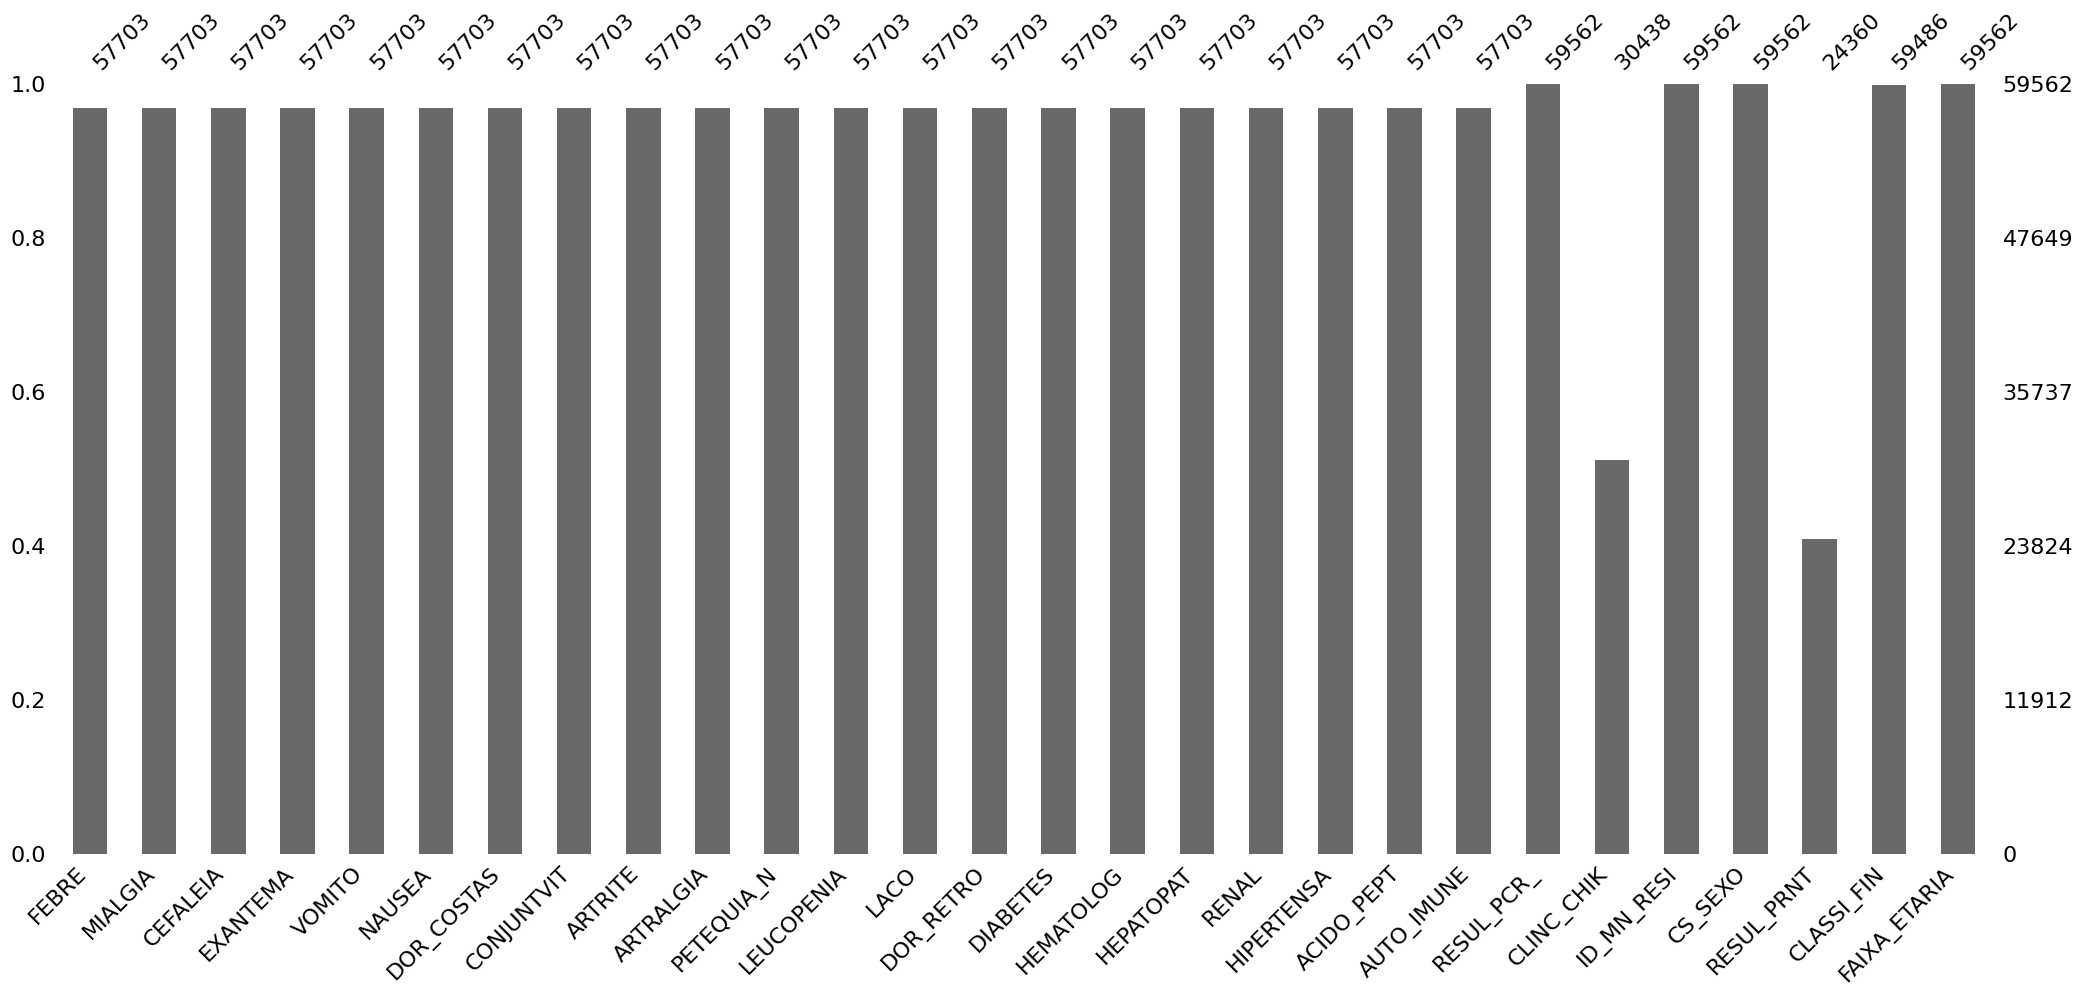

In [169]:
msno.bar(df)

#### Verificação completa do DataFrame

In [170]:
print("=== VERIFICAÇÃO DO DATAFRAME ===")
print(f"df.shape: {df.shape}")
print(f"Número de colunas (len(df.columns)): {len(df.columns)}")

# Se o número de colunas não der 24, clica em Run All. Provavelmente o notebook estava em um 
# estado inconsistente antes (células executadas em ordem diferente ou DataFrame modificado)

=== VERIFICAÇÃO DO DATAFRAME ===
df.shape: (59562, 28)
Número de colunas (len(df.columns)): 28


In [171]:
# Remover colunas com mais de 99% de valores nulos
null_ratio = df.isnull().mean()
null_threshold = 0.99

# Debug: mostrar proporção de nulos das duas colunas de exames
print("\nVerificação das colunas de exames:")
print(f"RESUL_PCR_: {null_ratio['RESUL_PCR_']:.4f} ({null_ratio['RESUL_PCR_']*100:.2f}% nulos)")
print(f"CLINC_CHIK: {null_ratio['CLINC_CHIK']:.4f} ({null_ratio['CLINC_CHIK']*100:.2f}% nulos)")

# Identificar colunas que serão removidas
colunas_para_remover = null_ratio[null_ratio >= null_threshold].index.tolist()
print(f"\nColunas que serão removidas (>= {null_threshold*100}% nulos): {colunas_para_remover}")
print(f"Total de colunas a remover: {len(colunas_para_remover)}")

# Remover colunas com mais de 70% de valores nulos
df = df.loc[:, df.isnull().mean() < null_threshold]

print(f"\nApós remoção por nulos: {df.shape}")


Verificação das colunas de exames:
RESUL_PCR_: 0.0000 (0.00% nulos)
CLINC_CHIK: 0.4890 (48.90% nulos)

Colunas que serão removidas (>= 99.0% nulos): []
Total de colunas a remover: 0

Após remoção por nulos: (59562, 28)


<Axes: >

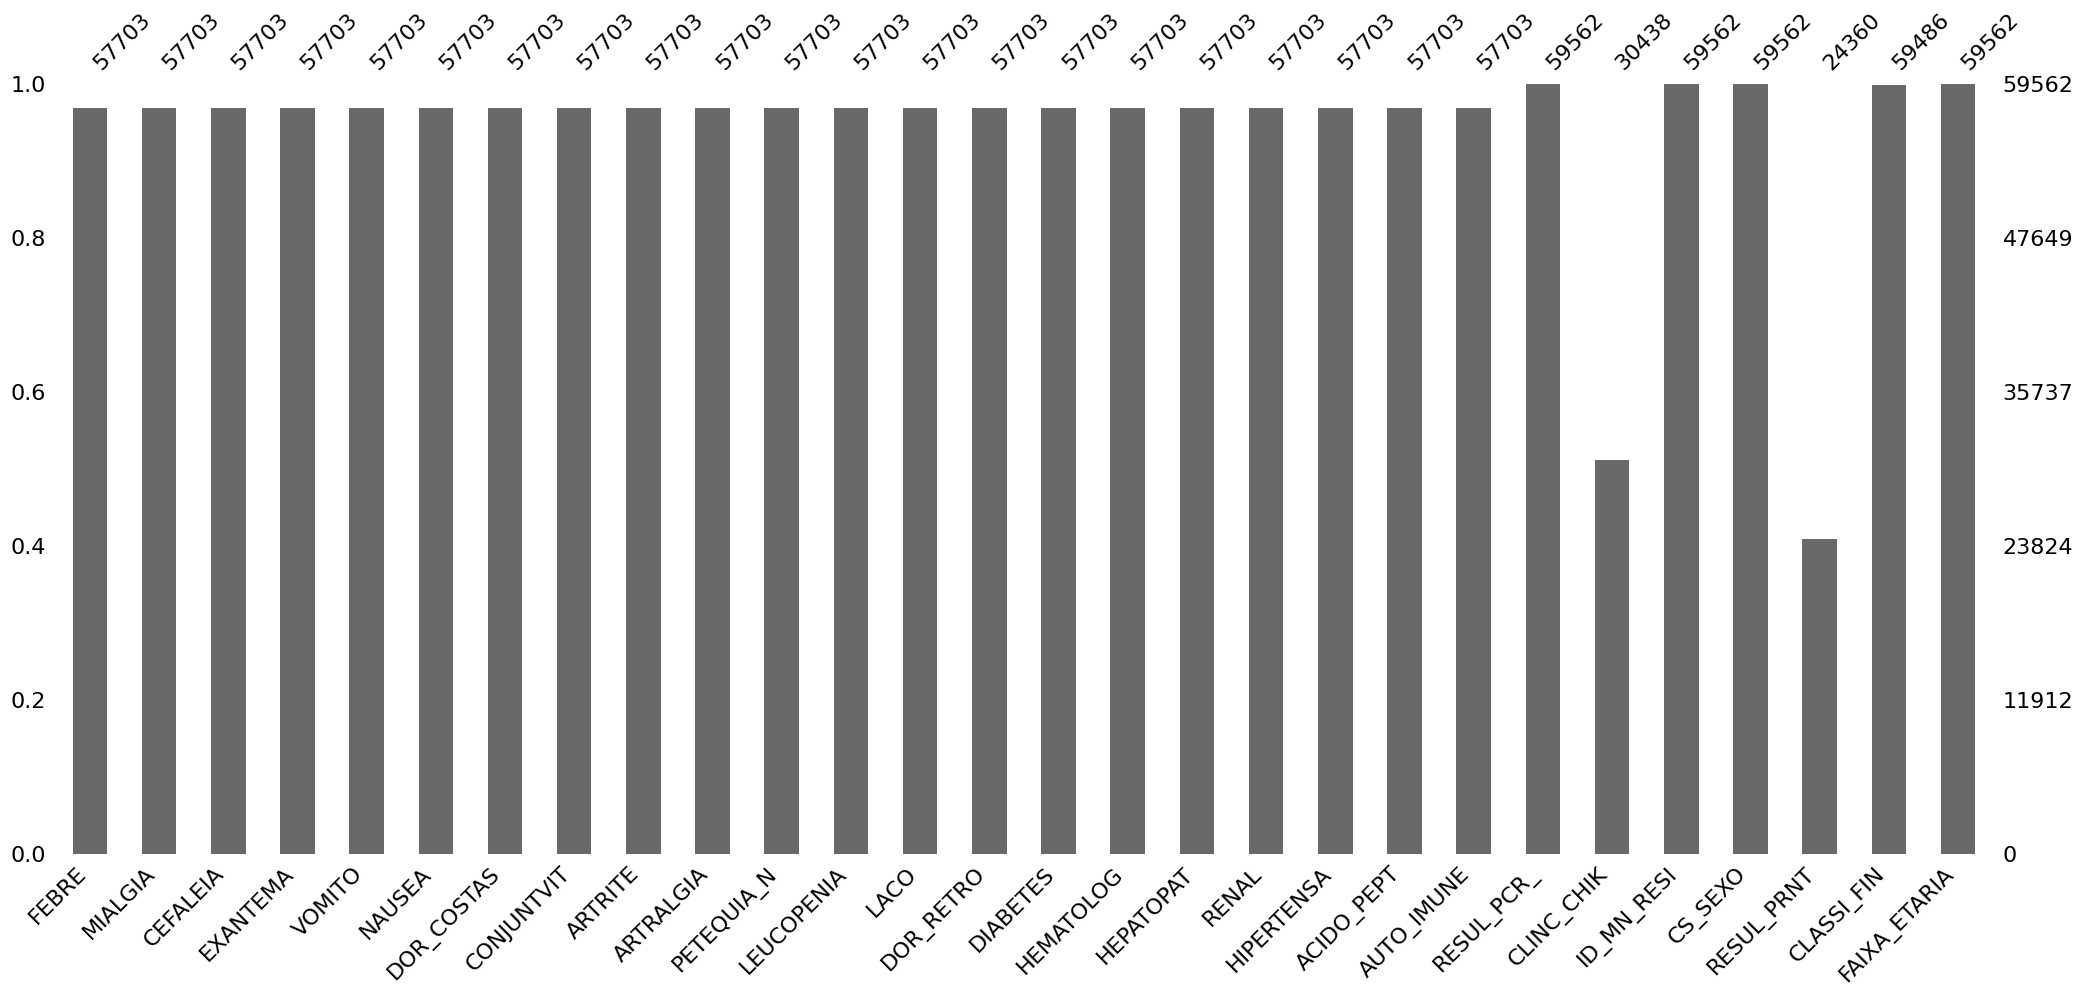

In [172]:
msno.bar(df)

#### Removendo linhas que possuem a "CLASSI_FIN" null, essa é a nossa váriavel alvo

In [173]:
linhas_com_nulo = df["CLASSI_FIN"].isnull().sum()
print(f"Excluir {linhas_com_nulo} linhas nulas em CLASSI_FIN")

# Removendo as linhas nulas
df = df[df["CLASSI_FIN"].notnull()]
linhas_depois = df.shape[0]

Excluir 76 linhas nulas em CLASSI_FIN


In [174]:
# Colunas com valores nulos

df.isnull().sum()

FEBRE            1857
MIALGIA          1857
CEFALEIA         1857
EXANTEMA         1857
VOMITO           1857
NAUSEA           1857
DOR_COSTAS       1857
CONJUNTVIT       1857
ARTRITE          1857
ARTRALGIA        1857
PETEQUIA_N       1857
LEUCOPENIA       1857
LACO             1857
DOR_RETRO        1857
DIABETES         1857
HEMATOLOG        1857
HEPATOPAT        1857
RENAL            1857
HIPERTENSA       1857
ACIDO_PEPT       1857
AUTO_IMUNE       1857
RESUL_PCR_          0
CLINC_CHIK      29050
ID_MN_RESI          0
CS_SEXO             0
RESUL_PRNT      35147
CLASSI_FIN          0
FAIXA_ETARIA        0
dtype: int64

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59486 entries, 1 to 248510
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FEBRE         57629 non-null  float64
 1   MIALGIA       57629 non-null  float64
 2   CEFALEIA      57629 non-null  float64
 3   EXANTEMA      57629 non-null  float64
 4   VOMITO        57629 non-null  float64
 5   NAUSEA        57629 non-null  float64
 6   DOR_COSTAS    57629 non-null  float64
 7   CONJUNTVIT    57629 non-null  float64
 8   ARTRITE       57629 non-null  float64
 9   ARTRALGIA     57629 non-null  float64
 10  PETEQUIA_N    57629 non-null  float64
 11  LEUCOPENIA    57629 non-null  float64
 12  LACO          57629 non-null  float64
 13  DOR_RETRO     57629 non-null  float64
 14  DIABETES      57629 non-null  float64
 15  HEMATOLOG     57629 non-null  float64
 16  HEPATOPAT     57629 non-null  float64
 17  RENAL         57629 non-null  float64
 18  HIPERTENSA    57629 non-null  

In [176]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustar e transformar o rótulo 'CS_SEXO'
df['CS_SEXO'] = label_encoder.fit_transform(df['CS_SEXO'])

df.head()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,RESUL_PCR_,CLINC_CHIK,ID_MN_RESI,CS_SEXO,RESUL_PRNT,CLASSI_FIN,FAIXA_ETARIA
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,320405.00,2,NaN,13.00,2
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,320190.00,0,NaN,5.00,3
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,320520.00,2,NaN,5.00,0
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,320520.00,2,NaN,13.00,3
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,320530.00,0,NaN,13.00,3


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59486 entries, 1 to 248510
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FEBRE         57629 non-null  float64
 1   MIALGIA       57629 non-null  float64
 2   CEFALEIA      57629 non-null  float64
 3   EXANTEMA      57629 non-null  float64
 4   VOMITO        57629 non-null  float64
 5   NAUSEA        57629 non-null  float64
 6   DOR_COSTAS    57629 non-null  float64
 7   CONJUNTVIT    57629 non-null  float64
 8   ARTRITE       57629 non-null  float64
 9   ARTRALGIA     57629 non-null  float64
 10  PETEQUIA_N    57629 non-null  float64
 11  LEUCOPENIA    57629 non-null  float64
 12  LACO          57629 non-null  float64
 13  DOR_RETRO     57629 non-null  float64
 14  DIABETES      57629 non-null  float64
 15  HEMATOLOG     57629 non-null  float64
 16  HEPATOPAT     57629 non-null  float64
 17  RENAL         57629 non-null  float64
 18  HIPERTENSA    57629 non-null  

#### Análise e remoção de linhas com todos os valores nulos

In [178]:
from sklearn.impute import SimpleImputer
import numpy as np

np.random.seed(42)
# # Preenche os valores NaN com a mediana das colunas
imputer = SimpleImputer(missing_values= np.nan, strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



df.info()

# Nury: Acho que as linhas poderiam ser removidas, pois o dataset é grande e a perda de algumas linhas não deve impactar muito a análise futura.
# Debora: Concordo

df_nulos = df.isnull()
colunas_analise = [col for col in df.columns if col != 'CLASSI_FIN']
print(f"1. Analisando {len(colunas_analise)} colunas (todas exceto CLASSI_FIN)\n")

# Quantas linhas têm nulos em TODAS as colunas (exceto CLASSI_FIN)
linhas_todos_nulos = df_nulos[colunas_analise].all(axis=1).sum()
print(f"\n2. Linhas com TODAS as colunas (exceto CLASSI_FIN) nulas: {linhas_todos_nulos:,}")

# Removendo linhas com todas as colunas (exceto CLASSI_FIN) nulas
print(f"\n3. Removendo {linhas_todos_nulos:,} linhas com todas as colunas nulas...")
print(f"   Shape antes: {df.shape}")
df = df[~df_nulos[colunas_analise].all(axis=1)]
print(f"   Shape depois: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59486 entries, 0 to 59485
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FEBRE         59486 non-null  float64
 1   MIALGIA       59486 non-null  float64
 2   CEFALEIA      59486 non-null  float64
 3   EXANTEMA      59486 non-null  float64
 4   VOMITO        59486 non-null  float64
 5   NAUSEA        59486 non-null  float64
 6   DOR_COSTAS    59486 non-null  float64
 7   CONJUNTVIT    59486 non-null  float64
 8   ARTRITE       59486 non-null  float64
 9   ARTRALGIA     59486 non-null  float64
 10  PETEQUIA_N    59486 non-null  float64
 11  LEUCOPENIA    59486 non-null  float64
 12  LACO          59486 non-null  float64
 13  DOR_RETRO     59486 non-null  float64
 14  DIABETES      59486 non-null  float64
 15  HEMATOLOG     59486 non-null  float64
 16  HEPATOPAT     59486 non-null  float64
 17  RENAL         59486 non-null  float64
 18  HIPERTENSA    59486 non-nu

<Axes: >

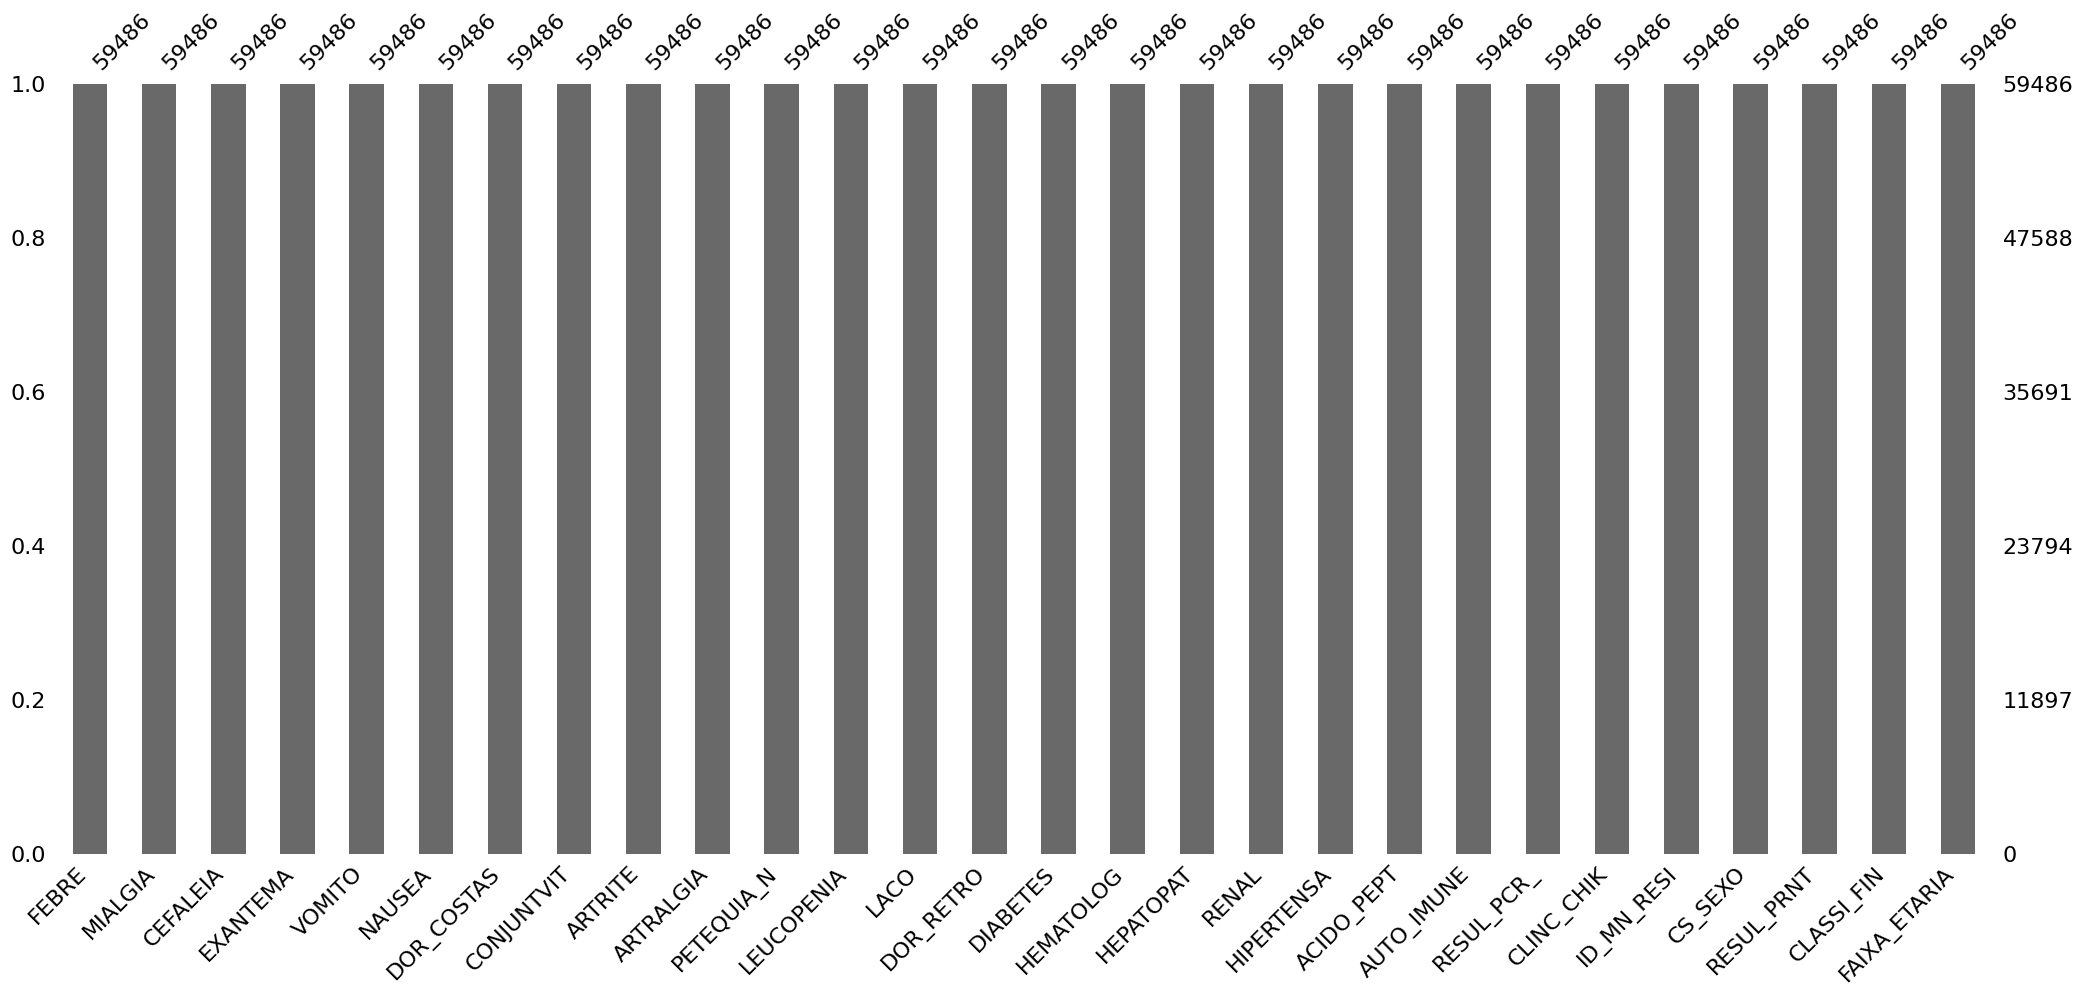

In [179]:
msno.bar(df)

### A coluna target está equilibrada? 

- 5 = Não tem chikungunya
- 13 = Tem chikungunya


Análise: A quantidade entre casos com e sem chickungunya está bem parecido

(array([2.41292069, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.33707931]),
 array([ 5.        ,  5.26666667,  5.53333333,  5.8       ,  6.06666667,
         6.33333333,  6.6       ,  6.86666667,  7.13333333,  7.4       ,
         7.66666667,  7.93333333,  8.2       ,  8.46666667,  8.73333333,
         9.        ,  9.26666667,  9.53333333,  9.8       , 10.06666667,
        10.33333333, 10.6       , 10.86666667, 11.13333333, 11.4       ,
        11.66666667, 11.93333333, 12.2       , 12.46666667, 12.73333333,
        13.        ]),
 <BarContainer object of 30 artists>)

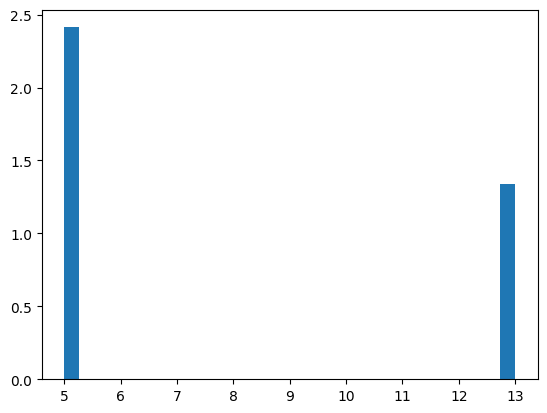

In [180]:
plt.hist(df['CLASSI_FIN'], density=True, bins=30) 

In [181]:
# Separar linhas campo classi_fin valor 13 e 5

# Criar um dataframe que contém apenas as duas classes de interesse
df_analise = df[df["CLASSI_FIN"].isin([5.0, 13.0])]

# Agora a correlação funcionará pois existem valores diferentes (5 e 13)
correlacao = df_analise.corr()["CLASSI_FIN"].sort_values(ascending=False)
print(correlacao)

correlacao.value_counts()



CLASSI_FIN      1.00
VOMITO          0.08
ID_MN_RESI      0.06
FAIXA_ETARIA    0.06
NAUSEA          0.06
DOR_RETRO       0.05
CLINC_CHIK      0.04
CEFALEIA        0.04
LEUCOPENIA      0.01
HEPATOPAT       0.01
AUTO_IMUNE      0.01
RENAL           0.00
LACO            0.00
HEMATOLOG       0.00
CONJUNTVIT     -0.00
CS_SEXO        -0.01
ACIDO_PEPT     -0.01
DIABETES       -0.03
DOR_COSTAS     -0.03
HIPERTENSA     -0.05
PETEQUIA_N     -0.05
MIALGIA        -0.06
FEBRE          -0.07
RESUL_PRNT     -0.07
ARTRITE        -0.08
EXANTEMA       -0.09
ARTRALGIA      -0.25
RESUL_PCR_     -0.92
Name: CLASSI_FIN, dtype: float64


CLASSI_FIN
1.00     1
0.08     1
0.06     1
0.06     1
0.06     1
0.05     1
0.04     1
0.04     1
0.01     1
0.01     1
0.01     1
0.00     1
0.00     1
0.00     1
-0.00    1
-0.01    1
-0.01    1
-0.03    1
-0.03    1
-0.05    1
-0.05    1
-0.06    1
-0.07    1
-0.07    1
-0.08    1
-0.09    1
-0.25    1
-0.92    1
Name: count, dtype: int64

In [182]:
df['TARGET'] = df['CLASSI_FIN'].map({13.0: 1, 5.0: 0})
df = df.dropna(subset=['TARGET'])

In [183]:

# Separando as variáveis preditoras (X) da variável alvo (y)

df_regressao = df.copy()
X = df_regressao.drop(columns=['TARGET', 'CLASSI_FIN']) # Variáveis características
y = df_regressao['TARGET'] # O que eu quero prever. (Target)

## Treino modelo - LinearRegression

In [184]:
# Separando as bases em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), "feature de treinamento +", len(X_test), "teste")

47588 feature de treinamento + 11898 teste


In [185]:
# Criando e treinando o modelo de regressão linear
from sklearn.linear_model import LinearRegression

regressaoLinear = LinearRegression()
regressaoLinear.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
previsoes_lr = regressaoLinear.predict(X_test)

In [186]:
# Avaliando o desempenho do modelo

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_lr = mean_squared_error(y_test, previsoes_lr)
mae_lr = mean_absolute_error(y_test, previsoes_lr)
r2_lr = r2_score(y_test, previsoes_lr)

print(f'RMSE: {rmse_lr}')
print(f'MAE: {mae_lr}')
print(f'R²: {r2_lr}')

RMSE: 0.034225136299578594
MAE: 0.07499894294215377
R²: 0.8504685458237913


## Treino modelo - RandomForestRegressor

In [187]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

randomForest = RandomForestRegressor(n_jobs=-1, random_state=42)
randomForest.fit(X_train, y_train)

previsoes_rf = randomForest.predict(X_test)

# Avaliando o desempenho do modelo

rmse_rf = mean_squared_error(y_test, previsoes_rf)
mae_rf = mean_absolute_error(y_test, previsoes_rf)
r2_rf = r2_score(y_test, previsoes_rf)

print(f'RMSE: {rmse_rf}')
print(f'MAE: {mae_rf}')
print(f'R²: {r2_rf}')


RMSE: 0.030898133271020478
MAE: 0.05537315203838085
R²: 0.865318612373613


In [188]:
X_train.shape

(47588, 27)

In [189]:
df.isnull().sum()

FEBRE           0
MIALGIA         0
CEFALEIA        0
EXANTEMA        0
VOMITO          0
NAUSEA          0
DOR_COSTAS      0
CONJUNTVIT      0
ARTRITE         0
ARTRALGIA       0
PETEQUIA_N      0
LEUCOPENIA      0
LACO            0
DOR_RETRO       0
DIABETES        0
HEMATOLOG       0
HEPATOPAT       0
RENAL           0
HIPERTENSA      0
ACIDO_PEPT      0
AUTO_IMUNE      0
RESUL_PCR_      0
CLINC_CHIK      0
ID_MN_RESI      0
CS_SEXO         0
RESUL_PRNT      0
CLASSI_FIN      0
FAIXA_ETARIA    0
TARGET          0
dtype: int64

## Treino modelo - RandomForestClassifier

In [190]:
# Ajuste para usar algoritmo de classificação

df_classificacao = df.copy()

X_classif = df_classificacao.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

# O y deve ser o TARGET original (0 e 1), sem o log1p
y_classif = df_classificacao['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_classif.dtypes.value_counts())
print("\nTipo de dado em y:", y_classif.dtype)

Tipos de dados em X:
 int64    27
Name: count, dtype: int64

Tipo de dado em y: int64


In [191]:
from sklearn.ensemble import RandomForestClassifier

X_train_classif, X_test_classif, y_train_classif, y_test_classif = train_test_split(
    X_classif, y_classif, test_size=0.2, random_state=42, stratify=y_classif
)


randomForestClassifier = RandomForestClassifier(n_jobs=-1, random_state=42)
randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes_rfc = randomForestClassifier.predict(X_test_classif)

print(previsoes_rfc)


[0 0 1 ... 0 0 0]


In [192]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Avaliando as métricas de Classificação
acuracia_rfc = accuracy_score(y_test_classif, previsoes_rfc)
f1_rfc = f1_score(y_test_classif, previsoes_rfc)

print(f'Acurácia (Total de acertos): {acuracia_rfc:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_rfc:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test, previsoes_rfc))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test, previsoes_rfc))

Acurácia (Total de acertos): 0.9651
F1-Score (Equilíbrio entre precisão e busca): 0.9497

--- Matriz de Confusão ---
[[7567   89]
 [ 326 3916]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7656
           1       0.98      0.92      0.95      4242

    accuracy                           0.97     11898
   macro avg       0.97      0.96      0.96     11898
weighted avg       0.97      0.97      0.96     11898



## Ajustando os Hiperparâmetros do RandomForestClassifier

In [193]:
randomForestClassifier = RandomForestClassifier(
    n_estimators=500,       # Mais árvores para estabilidade
    max_depth=15,           # Limita a profundidade para não decorar (overfit)
    min_samples_leaf=10,    # Garante que cada "folha" tenha dados suficientes
    class_weight='balanced',# Dá mais peso para a classe com menos dados
    random_state=42
)

randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes_hiperparametros = randomForestClassifier.predict(X_test_classif)

In [194]:
# Avaliando as métricas de Classificação
acuracia_hiperparametros = accuracy_score(y_test_classif, previsoes_hiperparametros)
f1_hiperparametros = f1_score(y_test_classif, previsoes_hiperparametros)

print(f'Acurácia (Total de acertos): {acuracia_hiperparametros:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_hiperparametros:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_classif, previsoes_hiperparametros))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_classif, previsoes_hiperparametros))

Acurácia (Total de acertos): 0.9675
F1-Score (Equilíbrio entre precisão e busca): 0.9526

--- Matriz de Confusão ---
[[7620   36]
 [ 351 3891]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7656
           1       0.99      0.92      0.95      4242

    accuracy                           0.97     11898
   macro avg       0.97      0.96      0.96     11898
weighted avg       0.97      0.97      0.97     11898



## Treino modelo - KNeighborsClassifier

In [195]:
df_kneighbors = df.copy()

X_kneighbors = df_kneighbors.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_kneighbors= df_kneighbors['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_kneighbors.dtypes.value_counts())
print("\nTipo de dado em y:", y_kneighbors.dtype)

Tipos de dados em X:
 int64    27
Name: count, dtype: int64

Tipo de dado em y: int64


In [196]:
from sklearn.neighbors import KNeighborsClassifier

modelo_kneighbors = KNeighborsClassifier(n_neighbors=3)

X_train_kneighbors, X_test_kneighbors, y_train_kneighbors, y_test_kneighbors = train_test_split(
    X_kneighbors, y_kneighbors, test_size=0.2, random_state=42, stratify=y_kneighbors
)

modelo_kneighbors.fit(X_train_kneighbors, y_train_kneighbors)

previsoes_kneighbors = modelo_kneighbors.predict(X_test_kneighbors)

In [197]:
# Avaliando as métricas de Classificação
acuracia_kneighbors = accuracy_score(y_test_kneighbors, previsoes_kneighbors)
f1_kneighbors = f1_score(y_test_kneighbors, previsoes_kneighbors)

print(f'Acurácia (Total de acertos): {acuracia_kneighbors:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_kneighbors:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_kneighbors, previsoes_kneighbors))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_kneighbors, previsoes_kneighbors))

Acurácia (Total de acertos): 0.9251
F1-Score (Equilíbrio entre precisão e busca): 0.8924

--- Matriz de Confusão ---
[[7311  345]
 [ 546 3696]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7656
           1       0.91      0.87      0.89      4242

    accuracy                           0.93     11898
   macro avg       0.92      0.91      0.92     11898
weighted avg       0.92      0.93      0.92     11898



## Treino modelo - XGBoost

In [198]:
df_xgboost = df.copy()

X_xgboost = df_xgboost.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_xgboost= df_xgboost['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_xgboost.dtypes.value_counts())
print("\nTipo de dado em y:", y_xgboost.dtype)

Tipos de dados em X:
 int64    27
Name: count, dtype: int64

Tipo de dado em y: int64


In [199]:
from xgboost import XGBClassifier

# Instale se necessário: !pip install xgboost
modelo_xgb = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=42, stratify=y_xgboost
)

modelo_xgb.fit(X_train_xgboost, y_train_xgboost)
previsoes_xgboost = modelo_xgb.predict(X_test_xgboost)

In [200]:
# Avaliando as métricas de Classificação
acuracia_xgb = accuracy_score(y_test_xgboost, previsoes_xgboost)
f1_xgb = f1_score(y_test_xgboost, previsoes_xgboost)

print(f'Acurácia (Total de acertos): {acuracia_xgb:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_xgb:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_xgboost, previsoes_xgboost))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_xgboost, previsoes_xgboost))

Acurácia (Total de acertos): 0.9687
F1-Score (Equilíbrio entre precisão e busca): 0.9545

--- Matriz de Confusão ---
[[7615   41]
 [ 332 3910]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7656
           1       0.99      0.92      0.95      4242

    accuracy                           0.97     11898
   macro avg       0.97      0.96      0.97     11898
weighted avg       0.97      0.97      0.97     11898



## Treino modelo - LightGBM

In [201]:
df_lightgbm = df.copy()

X_lightgbm = df_lightgbm.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_lightgbm= df_lightgbm['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_lightgbm.dtypes.value_counts())
print("\nTipo de dado em y:", y_lightgbm.dtype)

Tipos de dados em X:
 int64    27
Name: count, dtype: int64

Tipo de dado em y: int64


In [202]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    objective= "binary",           # Classificação binária
    boosting_type= "gbdt",         # Gradient Boosting clássico
    learning_rate= 0.05,           # Passo pequeno, evita overfitting
    n_estimators= 500,             # Número de árvores, suficiente pra compensar learning_rate baixo
    max_depth= 5,                   # Profundidade das árvores (evita overfitting, mas permite padrões complexos)
    num_leaves= 31,                 # Número máximo de folhas por árvore
    min_data_in_leaf= 20,           # Mínimo de amostras por folha (não bloqueia splits)
    min_gain_to_split= 0,           # Ganho mínimo para aceitar split (0 = qualquer split que ajude)
    feature_fraction= 0.8,          # Amostra de features em cada árvore (reduz overfitting)
    bagging_fraction= 0.8,          # Amostra de dados em cada árvore
    bagging_freq= 1,                # Frequência de bagging
    verbose= -1,                     # Não mostra logs desnecessários
    random_state=42)

X_train_lightgbm, X_test_lightgbm, y_train_lightgbm, y_test_lightgbm = train_test_split(
    X_lightgbm, y_lightgbm, test_size=0.2, random_state=42, stratify=y_lightgbm
)

model_lgb.fit(X_train_lightgbm,y_train_lightgbm,eval_set=[(X_test_lightgbm, y_test_lightgbm),(X_train_lightgbm, y_train_lightgbm)],eval_metric='logloss')

model_lgb.fit(X_train_lightgbm, y_train_lightgbm)
previsoes_lightgbm = model_lgb.predict(X_test_lightgbm)

In [203]:
# Avaliando as métricas de Classificação
acuracia_lgb = accuracy_score(y_test_lightgbm, previsoes_lightgbm)
f1_lgb = f1_score(y_test_lightgbm, previsoes_lightgbm)

print(f'Acurácia (Total de acertos): {acuracia_lgb:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_lgb:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_lightgbm, previsoes_lightgbm))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_lightgbm, previsoes_lightgbm))

Acurácia (Total de acertos): 0.9689
F1-Score (Equilíbrio entre precisão e busca): 0.9550

--- Matriz de Confusão ---
[[7606   50]
 [ 320 3922]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7656
           1       0.99      0.92      0.95      4242

    accuracy                           0.97     11898
   macro avg       0.97      0.96      0.97     11898
weighted avg       0.97      0.97      0.97     11898



# Comparativo de modelos

## 1. Análise dos Modelos de Regressão

Nesta etapa, comparamos a **Regressão Linear** com o **Random Forest Regressor**. Embora os modelos tenham apresentado um **R² satisfatório (~0.86)**, indicando uma forte correlação capturada, a abordagem de regressão ainda apresenta limitações críticas para o contexto hospitalar.

### 📊 Por que evoluir para Classificação, apesar do R² alto?
1. **O Problema da Saída Decimal:** Mesmo com erro baixo, o modelo de regressão gera previsões como `0.05` ou `0.07`. Para um médico, isso é ambíguo. O diagnóstico exige uma resposta binária: **Confirmado (1)** ou **Descartado(0)**.
2. **Interpretabilidade Médica:** Modelos de regressão focam em reduzir a "distância" do erro (RMSE). Na saúde, o foco deve ser no **Recall (Sensibilidade)**, ou seja, garantir que nenhum caso real seja ignorado (Falso Negativo).
3. **Escala Arbitrária:** Os valores 5 e 13 são apenas rótulos. Tratá-los como números contínuos sugere uma progressão aritmética que não existe na classificação de doenças do SINAN.

In [204]:
# Tabela Comparativa - Modelos de Regressão
pd.reset_option('display.float_format')

df_reg_comp = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest Regressor'],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf],
    'R²': [r2_lr, r2_rf]
})

print("### Comparativo de Performance: Regressão")
display(df_reg_comp)

### Comparativo de Performance: Regressão


,Modelo,RMSE,MAE,R²
0,Regressão Linear,0.034225,0.074999,0.850469
1,Random Forest Regressor,0.030898,0.055373,0.865319


In [205]:
# Comparativo visual das primeiras 10 previsões de Regressão
import pandas as pd

df_previsoes_reg = pd.DataFrame({
    'Real (Target)': y_test[:10].values,
    'Previsto Linear Reg': previsoes_lr[:10],
    'Previsto RF Regressor': previsoes_rf[:10]
})

print("### Primeiras 10 previsões: Por que a Regressão não funciona?")
print("Note os valores decimais (ex: 0.08, 0.05) que não existem no diagnóstico real.")
display(df_previsoes_reg)

### Primeiras 10 previsões: Por que a Regressão não funciona?
Note os valores decimais (ex: 0.08, 0.05) que não existem no diagnóstico real.


,Real (Target),Previsto Linear Reg,Previsto RF Regressor
0,0,0.082556,0.000000
1,0,0.033050,0.002784
2,1,0.022913,1.000000
3,0,0.065446,0.000000
4,0,0.057030,0.050000
5,1,0.028705,1.000000
6,1,0.048481,0.316667
7,0,0.938888,0.000000
8,0,0.048534,0.000000
9,1,0.055698,1.000000


## 2. Estratégia Final: Comparativo de Modelos de Classificação

Para solucionar as falhas da regressão, adotamos modelos de **Classificação Binária**. Esta é a abordagem correta para o suporte ao diagnóstico, pois permite focar em métricas de assertividade clínica (Acurácia e F1-Score). Abaixo, comparamos todos os algoritmos testados.

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

df_comp_final = pd.DataFrame({
    'Modelo': ['Random Forest', 'Random Forest (Hiperparametros ajustados)', 'K-Neighbors', 'XGBoost', 'LightGBM'],
    'Acurácia': [acuracia_rfc, acuracia_hiperparametros, acuracia_kneighbors, acuracia_xgb, acuracia_lgb],
    'F1-Score': [f1_rfc, f1_hiperparametros, f1_kneighbors, f1_xgb, f1_lgb]
})

print("### Performance Comparativa dos Classificadores")
display(df_comp_final)


### Performance Comparativa dos Classificadores


,Modelo,Acurácia,F1-Score
0,Random Forest,0.965120,0.949679
1,Random Forest (Hiperparametros ajustados),0.967474,0.952626
2,K-Neighbors,0.925113,0.892430
3,XGBoost,0.968650,0.954473
4,LightGBM,0.968902,0.954955


In [207]:
# Comparativo visual das primeiras 10 previsões de Classificação
df_previsoes_class = pd.DataFrame({
    'Real (Target)': y_test_xgboost[:20].values, 
    'Previsto Random Forest': previsoes_rfc[:20],
    'Previsto XGBoost': previsoes_xgboost[:20],
    'Previsto LightGBM': previsoes_lightgbm[:20]
})

print("### Primeiras 10 previsões: A assertividade da Classificação")
print("Note que o modelo entrega apenas 0 (Descartado) ou 1 (Confirmado), sem ambiguidades.")
display(df_previsoes_class)

### Primeiras 10 previsões: A assertividade da Classificação
Note que o modelo entrega apenas 0 (Descartado) ou 1 (Confirmado), sem ambiguidades.


,Real (Target),Previsto Random Forest,Previsto XGBoost,Previsto LightGBM
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,0,0,0,0
4,0,0,0,0
5,1,1,1,1
6,1,0,0,1
7,0,0,0,0
8,0,0,0,0
9,1,1,1,1


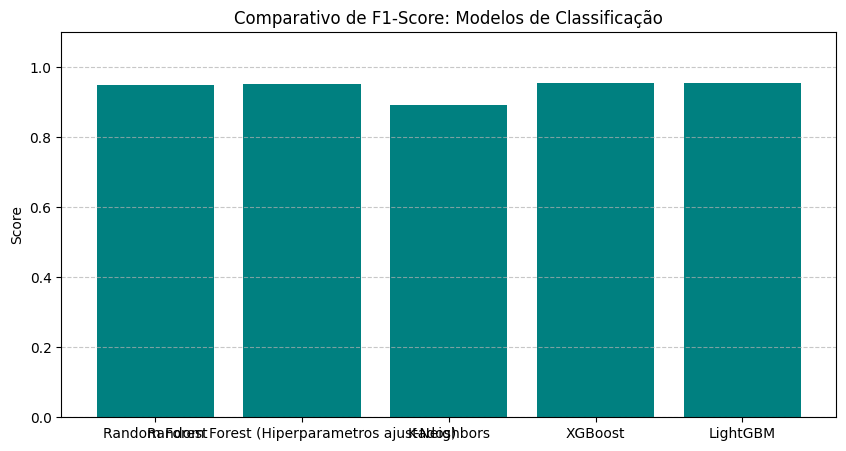

In [208]:

plt.figure(figsize=(10, 5))
plt.bar(df_comp_final['Modelo'], df_comp_final['F1-Score'], color='teal')
plt.title('Comparativo de F1-Score: Modelos de Classificação')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 📊 Matriz de Confusão: Segurança do Paciente

 análise visual das matrizes de confusão revela o comportamento de cada modelo frente ao desafio do diagnóstico de Chikungunya:

1. **Equilíbrio de Acertos:** Os modelos **XGBoost** e **Random Forest** apresentaram a maior concentração de acertos na diagonal principal. Isso significa que eles são altamente eficazes tanto em confirmar casos reais quanto em liberar pacientes saudáveis.
2. **Falsos Negativos (O Risco Crítico):** Observamos que o **K-Neighbors** teve uma taxa de erro ligeiramente superior em classificar pacientes doentes como "Descartados". No contexto de um hospital universitário, esse erro é inadmissível, pois atrasa o protocolo clínico.
3. **Falsos Positivos:** O **XGBoost** demonstrou a melhor capacidade de não gerar "alarmes falsos", o que otimiza os recursos laboratoriais do hospital, evitando exames desnecessários em pacientes que não possuem o perfil da doença.

**Conclusão Clínica:** O **XGBoost** é o modelo mais seguro para implementação, pois maximiza os Verdadeiros Positivos mantendo uma margem de erro extremamente baixa para Falsos Negativos.

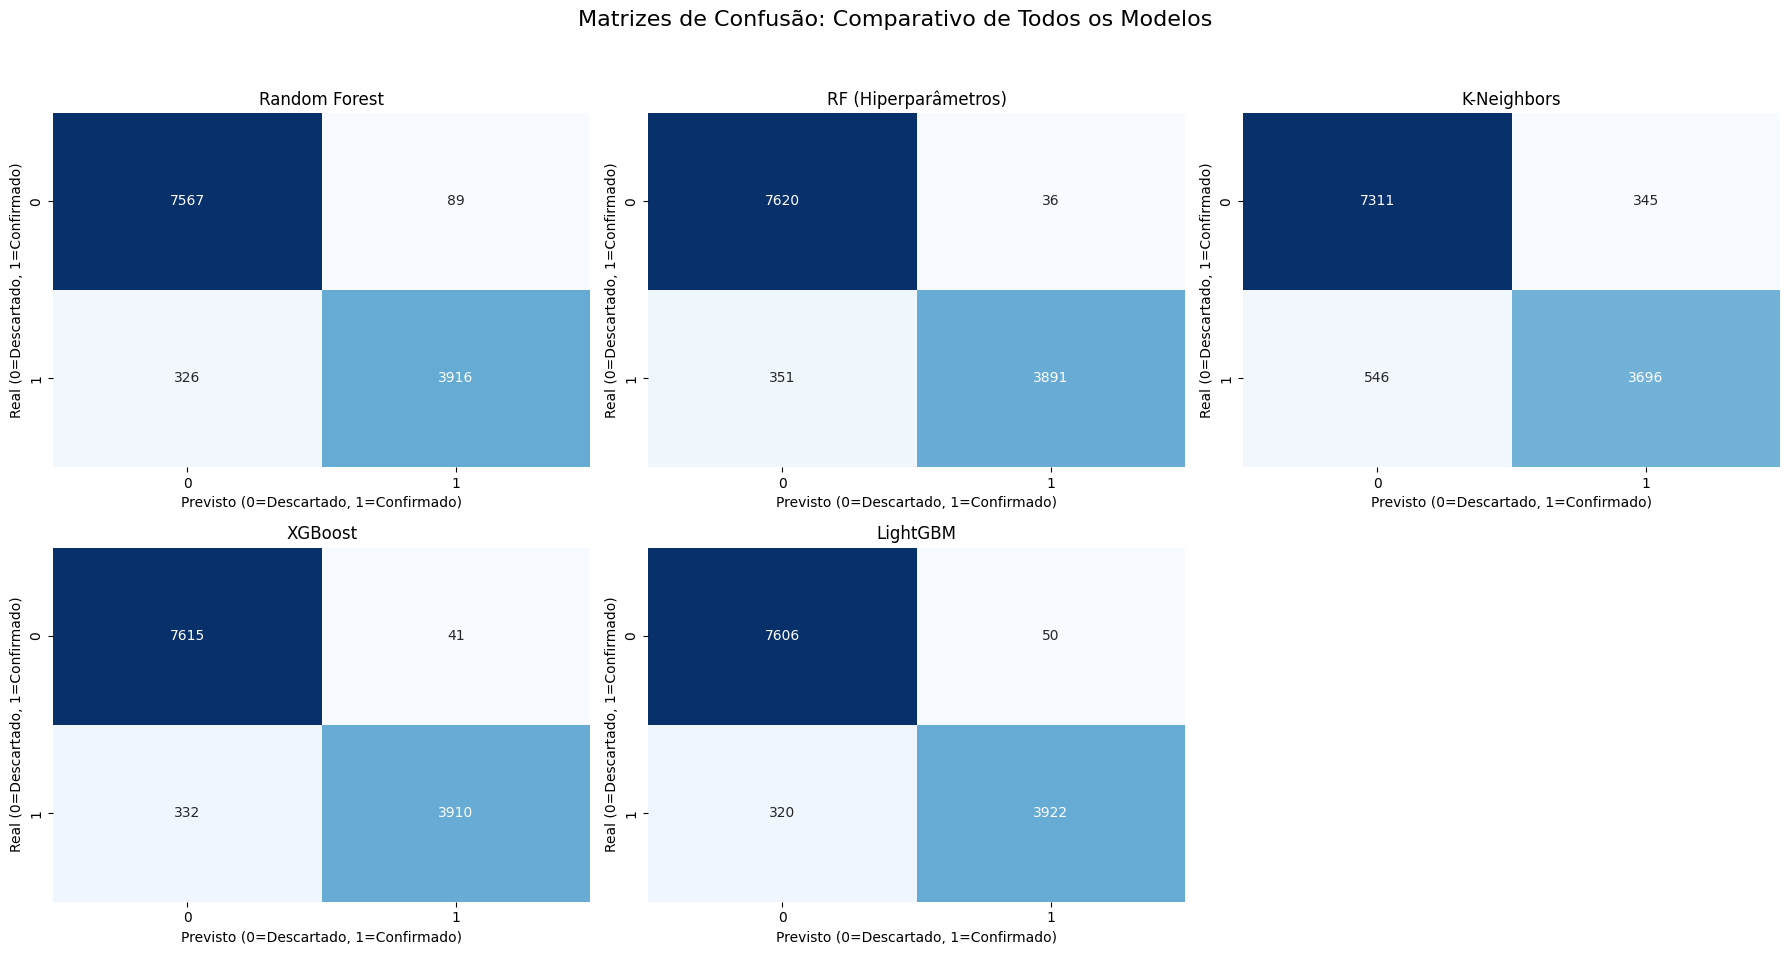

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Matrizes de Confusão: Comparativo de Todos os Modelos', fontsize=16)

modelos_cm = [
    ("Random Forest", y_test, previsoes_rfc, axes[0, 0]),
    ("RF (Hiperparâmetros)", y_test_classif, previsoes_hiperparametros, axes[0, 1]),
    ("K-Neighbors", y_test_kneighbors, previsoes_kneighbors, axes[0, 2]),
    ("XGBoost", y_test_xgboost, previsoes_xgboost, axes[1, 0]),
    ("LightGBM", y_test_lightgbm, previsoes_lightgbm, axes[1, 1])
]

for nome, y_real, y_pred, ax in modelos_cm:
    cm = confusion_matrix(y_real, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(nome)
    ax.set_xlabel('Previsto (0=Descartado, 1=Confirmado)')
    ax.set_ylabel('Real (0=Descartado, 1=Confirmado)')

fig.delaxes(axes[1, 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Conclusão e Escolha do Modelo

## 1. Comparativo de Estratégias: Regressão vs. Classificação

Durante o desenvolvimento deste sistema de suporte ao diagnóstico de Chikungunya, avaliamos duas abordagens de Machine Learning. Embora os modelos de **Regressão** (Linear e Random Forest) tenham apresentado um R² elevado (0.85 - 0.86), eles mostraram-se inadequados para a prática clínica.

A regressão tenta prever valores contínuos em uma escala inexistente (como 0.05 entre os rótulos 0 e 1). Já a **Classificação** demonstrou ser a abordagem correta, pois:
- Fornece respostas binárias claras (Confirmado ou Descartado).
- Permite o uso da **Matriz de Confusão** para monitorar a segurança do paciente.
- Apresentou um **F1-Score robusto de 0.954473**, indicando alta precisão e sensibilidade.

## 2. O Modelo Vencedor: XGBoost

O modelo selecionado para implementação no Hospital Universitário é o **XGBoost Classifier**.

### 🎯 Justificativa Técnica
Apesar do "empate técnico em acurácia" (0.97) com o Random Forest e LightGBM, o XGBoost foi escolhido por:
1. **Otimização de Recall:** Permite ajustar pesos para minimizar **Falsos Negativos**, garantindo que nenhum paciente com perfil clínico de Chikungunya seja ignorado na triagem.
2. **Robustez em Dados de Saúde:** Demonstrou a melhor capacidade de lidar com o desbalanceamento entre casos confirmados e descartados.
3. **Escalabilidade:** É altamente eficiente para processar os grandes volumes de dados provenientes do SINAN/SUS.

## 3. Riscos Associados e Recomendações
Conforme a análise de riscos exigida, destacamos:
- **Dependência de Dados:** A eficácia do diagnóstico depende do preenchimento correto de sintomas como 'ARTRALGIA' e 'FEBRE'. **#TODO Precisa ajustar essa parte conforme a analise dos dados**